In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
import autoencoder.aecExtraFeatures as Z_calculations

def addZToPrediction(model, data_point):
    reconstruction = model.decoder(model.encoder(data_point))

    Z_features = [Z_calculations.getZVector(data_point, reconstruction)]

    Z_features_tensor = tf.convert_to_tensor(Z_features, dtype=tf.float32)
    data_point = tf.convert_to_tensor(data_point, dtype=tf.float32)

    data_point = tf.concat([data_point, Z_features_tensor], 1)

    return data_point

In [3]:
def isAnomaly(data_point, model_1, model_2, threshold):

    # need autoencoder to return boolean isAnomaly
    isAnomaly = tf.math.less(tf.keras.losses.mae(model_1(data), data), threshold)

    # if the autoencoder doesn't find anything out of the ordinary, return False
    if not isAnomaly:
        return False

    data_point = addZToPrediction(model_1, data_point)

    # if the autoencoder sees something weird, run it through the isolation forest to make sure
    return model_2.predict(data_point)

In [4]:
from turtleIsolationForests.preprocessFeatures import preprocess_features

train_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_train.csv", index_col=0)
test_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_test.csv", index_col=0)

train_data, test_data, train_labels, test_labels = preprocess_features(train_dataframe, test_dataframe)

In [5]:
np_train_labels = train_labels.to_numpy()
np_test_labels = test_labels.to_numpy()

In [6]:
np_train_data = train_data.to_numpy()
np_test_data = test_data.to_numpy()

In [7]:
#min_val = tf.reduce_min(np_train_data)
#max_val = tf.reduce_max(np_train_data)

#np_train_data = (np_train_data - min_val) / (max_val - min_val)
#np_test_data = (np_test_data - min_val) / (max_val - min_val)

np_train_data = tf.cast(np_train_data, tf.float32)
np_test_data = tf.cast(np_test_data, tf.float32)

In [8]:
np_train_labels = np_train_labels.astype(bool)
np_test_labels = np_test_labels.astype(bool)

normal_train_data = np_train_data[np_train_labels]
normal_test_data = np_test_data[np_test_labels]

anomalous_train_data = np_train_data[~np_train_labels]
anomalous_test_data = np_test_data[~np_test_labels]

In [9]:
from autoencoder.autoencoder import AnomalyDetector
autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

In [11]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
2069/2105 [============================>.] - ETA: 0s - loss: 0.0402Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 6s 2ms/step - loss: 0.0400 - val_loss: 0.0782
Epoch 2/100
2105/2105 [==============================] - 3s 2ms/step - loss: 0.0243 - val_loss: 0.0757
Epoch 3/100
2105/2105 [==============================] - 4s 2ms/step - loss: 0.0225 - val_loss: 0.0651
Epoch 4/100
2105/2105 [==============================] - 4s 2ms/step - loss: 0.0184 - val_loss: 

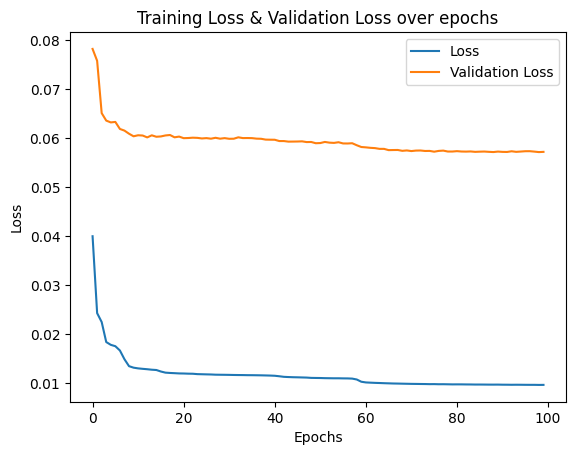

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss & Validation Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim([0,.0008])
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [24]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

2105/2105 [==============================] - 2s 1ms/step
Threshold:  0.034443587


In [25]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [26]:
test_predictions = predict(autoencoder, np_test_data, threshold)

tf.Tensor(
[[6.2539916  8.029118   1.0988152  ... 0.98600984 2.0278935  0.        ]
 [6.4334073  8.211189   1.4159207  ... 1.1357852  2.419      0.        ]
 [2.0337222  5.2904367  1.475067   ... 1.0815486  3.4206789  0.        ]
 ...
 [3.3940911  2.8468773  0.6501831  ... 1.1420196  1.6216717  1.5788141 ]
 [4.025786   2.8777776  0.         ... 1.1087654  1.7826889  0.92154527]
 [8.1895895  5.8423443  1.4960039  ... 2.7535548  2.7720659  0.        ]], shape=(22544, 8), dtype=float32)
tf.Tensor(
[[3.1277860e-19 2.0284073e-18 1.1692594e-18 ... 3.7089472e-17
  9.5584540e-10 1.9397478e-18]
 [1.1737546e-19 7.3776058e-19 3.2585922e-19 ... 1.6161274e-17
  2.6257274e-09 7.3443314e-19]
 [7.9479587e-13 7.6492090e-13 1.5227152e-13 ... 3.2667809e-12
  1.5094302e-03 2.2649909e-13]
 ...
 [7.4133933e-15 1.6479141e-14 5.3823191e-14 ... 4.0265676e-14
  4.0594350e-07 2.8302466e-14]
 [1.6716834e-13 5.6492056e-13 1.3356790e-12 ... 3.7085585e-13
  1.2325518e-03 4.6809003e-13]
 [8.1977231e-20 3.9432597e-18 

In [27]:
print_stats(test_predictions, test_labels)

Accuracy = 0.7936479772888574
Precision = 0.6824904408051368
Recall = 0.9741530223457935


In [38]:
predicted_anomalous = np_test_data[test_predictions]
predicted_anomalous_labels = np_test_labels[test_predictions]

In [39]:
def addZToData(data, model):
    data_with_Z = []
    for i in range(1, len(data)+1):
        data_with_Z.append(addZToPrediction(model, data[i-1:i]))

    data_with_Z_rf = []
    for i in range(len(data_with_Z)):
        data_with_Z_rf.append(np_train_data[:][:][i].numpy().reshape(1,46).squeeze())

    return  pd.DataFrame(data_with_Z_rf)

In [40]:
train_data_with_Z_df = addZToData(np_train_data, autoencoder)

anomalous_test_data_with_Z_df = addZToData(predicted_anomalous, autoencoder)

In [41]:
from turtleIsolationForests.extendedIsolationForest import ExtendedIsolationForest

contamination = sum(train_labels == 0) / len(train_labels)

model = ExtendedIsolationForest(contamination = contamination, random_state = None)
model.fit(train_data_with_Z_df, train_labels)

,anomaly_score,predicted_as_anomaly,is_normal
0,0.386294,False,0
1,0.415768,True,0
2,0.413571,True,1
3,0.399557,False,0
4,0.392266,False,0
...,...,...,...
13856,0.433506,True,0
13857,0.390495,False,1
13858,0.434123,True,0
13859,0.489848,True,1


In [47]:
predictions = model.predict(anomalous_test_data_with_Z_df)
predictions['is_normal'] = predicted_anomalous_labels
predictions

,anomaly_score,predicted_as_anomaly,is_normal
0,0.386294,False,True
1,0.415768,True,False
2,0.413571,True,True
3,0.399557,False,True
4,0.392266,False,False
...,...,...,...
13856,0.433506,True,False
13857,0.390495,False,True
13858,0.434123,True,True
13859,0.489848,True,False


In [48]:
from turtleIsolationForests.printResults import print_results

print_results(predictions)

true anomalies: 2009
false anomalies: 2392
false normals: 5151
true normals: 4309
precision: 0.45648716200863443
recall: 0.28058659217877097
f1-score: 0.34754778998356545
